# Scenario Theta

Scenario Theta is a synthetic stormwater system included in pystorms for prototyping control algorithms. This scenario is used in the pystorms paper to demonstrate the use of pystorms to evaluate the performance of control algorithms.

This notebook demonstrates the use of the equal-filling control algorithm for controlling outflows in the network. Please refer to the manuscript for more details of the approach. 

In [1]:
import pystorms
import numpy as np
import pandas as pd

### Generate Uncontrolled Baseline

In [2]:
# Run simulation with gates open
env_uncontrolled = pystorms.scenarios.theta()
done = False
while not done:
    done = env_uncontrolled.step()


 o  Retrieving project data

In [ ]:
# Uncontrolled response
uncontrolled_flows = pd.DataFrame.from_dict(env_uncontrolled.data_log['flows'])

In [7]:
def controller(depths,
               N=2,
               LAMBDA=0.5,
               MAX_DEPTH=2.0):
    
    # Compute the filling degree
    f = depths/MAX_DEPTH
    
    # Estimate the average filling degree
    f_mean = np.mean(f)
    
    # Compute psi
    psi = np.zeros(N)
    for i in range(0, N):
        psi[i] = f[i] - f_mean
        if psi[i] < 0.0 - 10**(-4):
            psi[i] = 0.0
        elif psi[i] >= 0.0 - 10**(-4) and psi[i] <= 0.0 + 10**(-4):
            psi[i] = f_mean
    
    # Assign valve positions
    actions = np.zeros(N)
    for i in range(0, N):
        if depths[i] > 0.0:
            k = 1.0/np.sqrt(2 * 9.81 * depths[i])
            action = k * LAMBDA * psi[i]/np.sum(psi)
            actions[i] = min(1.0, action)
    return actions

In [8]:


    
env = pystorms.scenarios.theta()
done = False
while not done:
    state = env.state()
    actions = controller(state)
    done = env.step(actions)


 o  Retrieving project data

In [9]:
flows = pd.DataFrame.from_dict(env.data_log['flow'])

<AxesSubplot:>

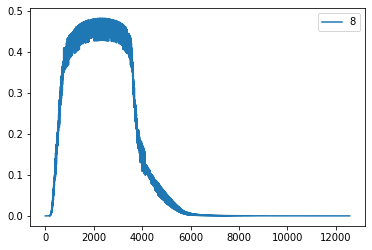

In [10]:
flows.plot()